In [4]:
%load_ext autoreload
%autoreload 2
import sys

path = "C:/Users/schiavaz/lava-nc/depth/"
sys.path.append(path)

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import open3d as o3d
from scipy.spatial.transform import Rotation as R
from tqdm import tqdm
import hdf5plugin
import h5py

import events_utils.filter as flt
import events_utils.visualize as vis
import events_utils.time_difference as td

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
img_time = np.loadtxt(path+"data/tum-vie/mocap-1d-trans-vi_gt_data/right_images/image_timestamps_right.txt")

In [157]:
start_time = 1.5
duration = 0.5

In [158]:
events_h5 = h5py.File(path + "data/tum-vie/mocap-1d-trans-events_right.h5")["events"]
t = np.array(events_h5["t"])
id_start = np.searchsorted(t, start_time * 10e6)
id_end = np.searchsorted(t, (start_time + duration) * 10e6)

events_raw = np.zeros((id_end - id_start, 4))
events_raw[:,0] = t[id_start:id_end]
events_raw[:,1] = events_h5["x"][id_start:id_end]
events_raw[:,2] = events_h5["y"][id_start:id_end]
events_raw[:,3] = events_h5["p"][id_start:id_end]

In [159]:
events_raw[:,2].max()

719.0

In [160]:
events = events_raw
shape = (720, 1280)

In [161]:
pose_hist = np.loadtxt(path + "data/tum-vie/mocap-1d-trans-vi_gt_data/mocap_data.txt")
pose_hist

array([[ 9.34329760e+05, -4.93599951e-01,  3.26365918e-01, ...,
        -5.52764349e-02,  2.27731481e-01,  9.71937120e-01],
       [ 9.42663760e+05, -4.93818283e-01,  3.26307505e-01, ...,
        -5.53953722e-02,  2.27805912e-01,  9.71914649e-01],
       [ 9.50996760e+05, -4.94036615e-01,  3.26252490e-01, ...,
        -5.55172302e-02,  2.27868214e-01,  9.71894562e-01],
       ...,
       [ 3.74926638e+07, -5.32860160e-01, -4.35860395e-01, ...,
        -1.03459373e-01,  2.83527702e-01,  9.52248454e-01],
       [ 3.75009968e+07, -5.32938719e-01, -4.35837030e-01, ...,
        -1.03786252e-01,  2.83581525e-01,  9.52181339e-01],
       [ 3.75093308e+07, -5.33028901e-01, -4.35789317e-01, ...,
        -1.03924878e-01,  2.83656448e-01,  9.52143252e-01]])

In [162]:
#TODO undistort events

In [163]:
K = np.array([
    [1049.048422241493, 0, 652.4780618014456],
    [0, 1049.5741104057763, 262.0071641027953], 
    [0, 0, 1]
])

In [164]:
def get_pose(t, pose_history):
    t = t * 10e6
    idx = np.searchsorted(pose_hist[:,0], t)
    pose = pose_hist[idx -1 if idx > 0 else 0]
    
    t = pose[1:4].reshape(3, 1)
    q = pose[4:] 
    r = R.from_quat(q).as_matrix()
    
    return r, t

In [165]:
def get_pose_matrix(t, pose_history):
    t = t * 10e6
    idx = np.searchsorted(pose_hist[:,0], t)
    pose = pose_hist[idx -1 if idx > 0 else 0]
    
    t = pose[1:4].reshape(3, 1)
    q = pose[4:] 
    r = R.from_quat(q).as_matrix()
    
    p_m = np.zeros((4, 4))
    p_m[:3, :3] = r
    p_m[:3,3] = t.flatten()
    p_m[3, 3] = 1
    
    return p_m

In [91]:
# dsi_shape = (180, 240, 50)
# dsi = np.zeros(dsi_shape)
# min_depth = 0.47
# max_depth = 2.4
# n_depths = 50
# inv_depths = np.array([(1 / max_depth) + (i / (n_depths / ((1/min_depth)-(1/max_depth)))) for i in range(n_depths)])
# inv_depths = np.flip(inv_depths)
# depths = 1/inv_depths
# e3 = np.array([0,0,1]).reshape(1, 3)

# test_img = np.zeros((180, 240))

# t_w_rv = get_pose_matrix(0.0, pose_hist)
# t_rv_w = np.linalg.inv(t_w_rv)

# for e in tqdm(events):
    
#     t_w_ev = get_pose_matrix(e[0], pose_hist)
#     t_rv_ev = t_rv_w @ t_w_ev
#     t_ev_rv = np.linalg.inv(t_rv_ev)
    
#     r = t_ev_rv[:3,:3]
#     t = t_ev_rv[:3,3].reshape(3, 1)
    
#     C = - np.linalg.inv(r) @ t
#     C = np.abs(C)
#     H = K @ (r + inv_depths[0] * (t @ e3)) @ np.linalg.inv(K)
    
#     x = int(e[1])
#     y = int(e[2])
#     px = np.array([x, y, 1]).reshape(3, 1)
    
#     pxz = np.linalg.inv(H) @ px
#     pxz /= pxz[2][0]
    
#     #TODO try discrete version
#     x0 = pxz[0][0]
#     y0 = pxz[1][0]
#     z0 = depths[0]
    
#     if x0 < 0 or x0 > 239 or y0 < 0 or y0 > 179:
#         continue
    
#     #test_img[int(y0), int(x0)] = 1

#     for i, zi in enumerate(depths[1:]):
#         d = (zi - z0) / (z0 - C[2][0])
#         xi = int(z0/zi * d * x0 + 1/zi*(1-d)*C[0][0]*K[0,0])
#         yi = int(z0/zi * d * y0 + 1/zi*(1-d)*C[1][0]*K[1, 1])

#         if xi < 0 or xi > 239 or yi < 0 or yi > 179:
#             continue

#         dsi[yi, xi, int(i)] += 1
#         #test_img[yi, xi] += 1

In [529]:
points = np.nonzero(dsi > 5)

In [530]:
%matplotlib qt
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(projection='3d')
ax.scatter(points[0], points[1], points[2], s=2, c=points[2], cmap="jet_r", vmin=0.5, vmax=2.5)
#ax.set_zlim3d([0.5, 2.5])
#vis._set_axes_equal(ax)
plt.show()

In [531]:
plt.imshow(test_img)

In [532]:
inv_depths

array([2.09343972, 2.05921986, 2.025     , 1.99078014, 1.95656028,
       1.92234043, 1.88812057, 1.85390071, 1.81968085, 1.78546099,
       1.75124113, 1.71702128, 1.68280142, 1.64858156, 1.6143617 ,
       1.58014184, 1.54592199, 1.51170213, 1.47748227, 1.44326241,
       1.40904255, 1.3748227 , 1.34060284, 1.30638298, 1.27216312,
       1.23794326, 1.2037234 , 1.16950355, 1.13528369, 1.10106383,
       1.06684397, 1.03262411, 0.99840426, 0.9641844 , 0.92996454,
       0.89574468, 0.86152482, 0.82730496, 0.79308511, 0.75886525,
       0.72464539, 0.69042553, 0.65620567, 0.62198582, 0.58776596,
       0.5535461 , 0.51932624, 0.48510638, 0.45088652, 0.41666667])

In [533]:
depths

array([0.47768273, 0.4856208 , 0.49382716, 0.50231564, 0.51110104,
       0.52019923, 0.5296272 , 0.53940321, 0.54954692, 0.56007944,
       0.57102359, 0.58240397, 0.59424718, 0.60658206, 0.61943987,
       0.63285458, 0.64686317, 0.66150598, 0.67682707, 0.69287469,
       0.70970177, 0.72736652, 0.74593308, 0.76547231, 0.78606272,
       0.80779146, 0.83075563, 0.85506367, 0.88083711, 0.90821256,
       0.93734419, 0.96840659, 1.0015983 , 1.03714601, 1.07530982,
       1.11638955, 1.16073266, 1.20874411, 1.26089873, 1.31775701,
       1.37998532, 1.44838213, 1.52391246, 1.60775371, 1.70135747,
       1.80653427, 1.92557187, 2.06140351, 2.21785293, 2.4       ])

In [534]:
plt.imshow(dsi[:,:,40])

In [94]:
n_depths = 50
dsi_shape = (shape[0], shape[1], n_depths)
dsi = np.zeros(dsi_shape)
min_depth = 0.47
max_depth = 2.4

inv_depths = np.array([(1 / max_depth) + (i / (n_depths / ((1/min_depth)-(1/max_depth)))) for i in range(n_depths)])
inv_depths = np.flip(inv_depths)
depths = 1/inv_depths
e3 = np.array([0,0,1]).reshape(1, 3)

t_w_rv = get_pose_matrix(events[0,0], pose_hist)
t_rv_w = np.linalg.inv(t_w_rv)

for e in tqdm(events[::100]):
    t_w_ev = get_pose_matrix(e[0], pose_hist)
    t_rv_ev = t_rv_w @ t_w_ev
    t_ev_rv = np.linalg.inv(t_rv_ev)
    
    r = t_ev_rv[:3,:3]
    t = t_ev_rv[:3,3].reshape(3, 1)

    C = - r.transpose() @ t

    #C = np.abs(C)
    z0 = depths[0]
    H_z0_inv = r
    H_z0_inv *= z0
    H_z0_inv[:,2] += t.flatten()
    
    H_z0_inv_px = K @ H_z0_inv @ np.linalg.inv(K)
    H_z0_px = np.linalg.inv(H_z0_inv_px)
    
    x = int(e[1])
    y = int(e[2])
    px = np.array([x, y, 1]).reshape(3, 1)
    
    pxz = H_z0_px @ px
    pxz /= pxz[2][0]
    
    #TODO try discrete version
    x0 = int(pxz[0][0])
    y0 = int(pxz[1][0])
    z0 = depths[0]
    
    if x0 < 0 or x0 >= dsi_shape[1] or y0 < 0 or y0 >= dsi_shape[0]:
        continue
    
    #test_img[int(y0), int(x0)] = 1

    for i, zi in enumerate(depths[1:]):
        a = z0 * (zi - C[2,0])
        bx = (z0 - zi) * (C[0, 0] * K[0,0] + C[2,0] * K[0,2])
        by = (z0 - zi) * (C[1, 0] * K[1, 1] + C[2, 0] * K[1, 2])
        d = zi * (z0 - C[2, 0])
        
#         a = int(a)
#         bx = int(bx)
#         by = int(by)
#         d = int(d)
        ad = a/d
        bxd = bx / d
        byd = by / d

        xi = int(x0 * ad + bxd)
        yi = int(y0 * ad + byd)
        
        if xi < 0 or xi >= dsi_shape[1] or yi < 0 or yi >= dsi_shape[0]:
            continue
        dsi[yi, xi, int(i)] += 1
        #test_img[yi, xi] += 1

100%|████████████████████████████████████████████████████████████████████████| 265356/265356 [02:31<00:00, 1754.96it/s]


In [175]:
points = np.nonzero(dsi > 30)
%matplotlib qt
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(projection='3d')
ax.scatter(points[0], points[1], points[2], s=2, c=points[2], cmap="jet_r", vmin=0.5, vmax=2.5)
#ax.set_zlim3d([0.5, 2.5])
#vis._set_axes_equal(ax)
plt.show()

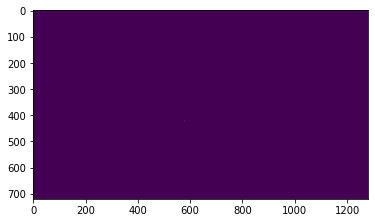

In [95]:
plt.imshow(dsi[:,:,7])

In [170]:
sub_shape = (8, 8)
new_shape = (int(shape[0] / sub_shape[0]), int(shape[1] / sub_shape[1]))
sub_events = []
count = np.zeros(new_shape)
for e in tqdm(events):
    x = int(e[1] / sub_shape[1])
    y = int(e[2] / sub_shape[0])
    
    count[y, x] += 1
    
    if count[y, x] >=50:
        sub_events.append([e[0], x, y, e[3]])
        count[y, x] = 0
        
# K = np.array([
#     [calib[0]/2, 0, calib[2]/2],
#     [0, calib[1]/2, calib[3]/2], 
#     [0, 0, 1]
# ])

100%|██████████████████████████████████████████████████████████████████| 85896863/85896863 [03:23<00:00, 422973.04it/s]


In [171]:
K = np.array([
    [1049.048422241493, 0, 652.4780618014456],
    [0, 1049.5741104057763, 262.0071641027953], 
    [0, 0, 1]
])
K = K / 8
K[2, 2] = 1

In [172]:
sub_events = np.array(sub_events)

In [196]:
n_depths = 20
dsi_shape = (new_shape[0], new_shape[1], n_depths)
dsi = np.zeros(dsi_shape)
min_depth = 0.47
max_depth = 2.4
inv_depths = np.array([(1 / max_depth) + (i / (n_depths / ((1/min_depth)-(1/max_depth)))) for i in range(n_depths)])
inv_depths = np.flip(inv_depths)
depths = 1/inv_depths
e3 = np.array([0,0,1]).reshape(1, 3)

#test_img = np.zeros((180, 240))
bxs = []

t_w_rv = get_pose_matrix(events[0,0], pose_hist)
t_rv_w = np.linalg.inv(t_w_rv)
pose_t = -1.0

def c_precomputed(C):
    precomputed = np.zeros((len(depths), 3))
    z0 = depths[0]

    for i, zi in enumerate(depths[1:]):
            a = z0 * (zi - C[2,0])
            bx = (z0 - zi) * (C[0, 0] * K[0,0] + C[2,0] * K[0,2])
            by = (z0 - zi) * (C[1, 0] * K[1, 1] + C[2, 0] * K[1, 2])
            d = zi * (z0 - C[2, 0])

            ad = a/d
            bxd = bx / d
            byd = by / d

            precomputed[i, 0] = ad
            precomputed[i, 1] = bxd
            precomputed[i, 2] = byd
    return precomputed

for e in tqdm(sub_events):
    if e[0] > pose_t:
        t_w_ev = get_pose_matrix(e[0], pose_hist)
        t_rv_ev = t_rv_w @ t_w_ev
        t_ev_rv = np.linalg.inv(t_rv_ev)

        r = t_ev_rv[:3,:3]
        t = t_ev_rv[:3,3].reshape(3, 1)

        C = - r.transpose() @ t

        #C = np.abs(C)
        z0 = depths[0]
        H_z0_inv = r
        H_z0_inv *= z0
        H_z0_inv[:,2] += t.flatten()

        H_z0_inv_px = K @ H_z0_inv @ np.linalg.inv(K)
        H_z0_px = np.linalg.inv(H_z0_inv_px)
        
        pose_t = pose_hist[np.searchsorted(pose_hist[:,0], e[0]), 0]
        
        precomputed = c_precomputed(C)
        
    x = int(e[1])
    y = int(e[2])
    px = np.array([x, y, 1]).reshape(3, 1)
    
    pxz = H_z0_px @ px
    pxz /= pxz[2][0]
    
    #TODO try discrete version
    x0 = int(pxz[0][0])
    y0 = int(pxz[1][0])
    z0 = depths[0]
    
    if x0 < 0 or x0 >= dsi_shape[1] or y0 < 0 or y0 >= dsi_shape[0]:
        continue
    
    #test_img[int(y0), int(x0)] = 1

    for i, zi in enumerate(depths[1:]):
        
        ad = precomputed[i, 0]
        bxd = precomputed[i, 1]
        byd = precomputed[i, 2]
        
        xi = int(x0 * ad + bxd)
        yi = int(y0 * ad + byd)
        
        if xi < 0 or xi >= dsi_shape[1] or yi < 0 or yi >= dsi_shape[0]:
            continue
        dsi[yi, xi, int(i)] += 1
        
        x0 = x0 * ad + bxd
        y0 = y0 * ad + byd
        z0 = zi
        #test_img[yi, xi] += 1

100%|█████████████████████████████████████████████████████████████████████| 1710886/1710886 [01:48<00:00, 15790.28it/s]


In [197]:
points = np.nonzero(dsi > 30)
%matplotlib qt
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(projection='3d')
ax.scatter(points[0], points[1], points[2], s=2, c=points[2], cmap="jet_r", vmin=0.5, vmax=2.5)
#ax.set_zlim3d([0.5, 2.5])
#vis._set_axes_equal(ax)
plt.show()

In [198]:
plt.figure(figsize=(10, 10))
m = plt.imshow(dsi[:,:,18], interpolation="none", vmax=100)
plt.colorbar(mappable=m)

In [199]:
dsi_max = dsi.max(axis=2)
dsi_max_id = np.argmax(dsi, axis=2)
dsi_max_val = depths[dsi_max_id]

In [200]:
depths[dsi_max_id]

array([[0.4896896, 0.4896896, 0.4896896, ..., 0.4896896, 0.4896896,
        0.4896896],
       [0.4896896, 0.4896896, 0.4896896, ..., 0.4896896, 0.4896896,
        0.4896896],
       [0.4896896, 0.4896896, 0.4896896, ..., 0.4896896, 0.4896896,
        0.4896896],
       ...,
       [0.4896896, 0.4896896, 0.4896896, ..., 0.4896896, 0.4896896,
        0.4896896],
       [0.4896896, 0.4896896, 0.4896896, ..., 0.4896896, 0.4896896,
        0.4896896],
       [0.4896896, 0.4896896, 0.4896896, ..., 0.4896896, 0.4896896,
        0.4896896]])

In [201]:
plt.imshow(dsi_max)

In [202]:
plt.hist(dsi_max.flatten(), 100);

In [203]:
import cv2 as cv

dsi_u = np.uint8(dsi_max)
dsi_thresh = cv.adaptiveThreshold(dsi_u,1,cv.ADAPTIVE_THRESH_GAUSSIAN_C ,\
            cv.THRESH_BINARY, 5, -10)

In [204]:
plt.imshow(dsi_thresh)

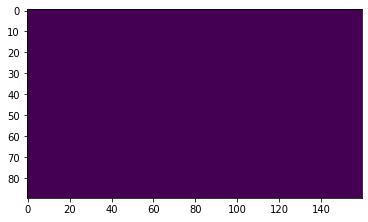

In [193]:
plt.imshow(dsi_max_val)

In [194]:
dsi_m = np.ma.masked_where(dsi_thresh == 0, dsi_max_val)

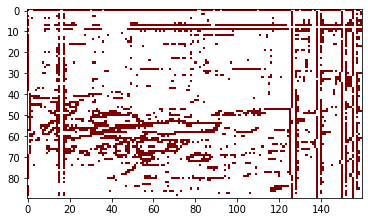

In [195]:
%matplotlib inline
plt.imshow(dsi_m, cmap="jet_r", interpolation="none")

In [546]:
bxs = np.array(bxs)

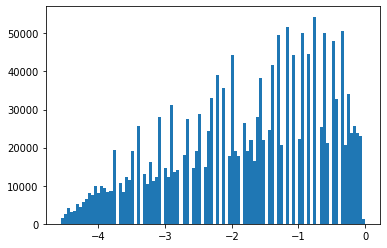

In [547]:
plt.hist(bxs, 100);

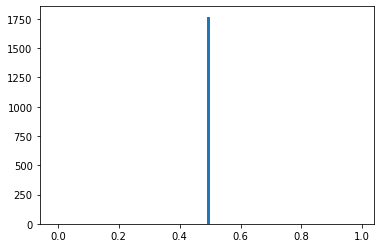

In [145]:
plt.hist(dsi_m.compressed(), 100);